# JS_EDA__X_Y_LOCATION

## Contents
- [Background](#Background)
- [Count starting nulls](#Count-Starting-Nulls)
- [Create Location Dictionaries and Update X,Y](#Create-Location-Dictionaries-and-Update-X,Y)
- [Explore LOCATIONS with X,Y still missing](#Explore-LOCATIONS-with-X,Y-still-missing)
- [Write location_xy.csv file](#Write-location_xy.csv-file)
- [How to use location_xy.csv](#How-to-use-location_xy.csv-file)

- [Plotting X,Y with Basemap](#Plotting-X,Y-with-Basemap)

## Background

### Notebook Focus

This notebook focuses on missing location information in 3 fields of the collisions.csv starting data:
- X (longitude)
- Y (latitude)
- LOCATION (text description)

|Case|X|Y|LOCATION|Number of records|Comments|
|---|---|---|---|---|---|
|1|yes|yes|yes|212975|No modifications required|
|2|yes|yes|no|0|No modifications at this time|
|3|no|no|yes|**2885**|See below|
|4|no|no|no|4576|No modifications possible|

Total number of records: 220436

### Notebook Findings
Methods for filling in the 2885 missing X, Y data had varying levels of success


|Method|Filled values|Comments|
|---|---|---|
|Use data from other records in the original collisions.csv|4||
|Use X, Y data from the intersections.csv data file|188|
|Use research on Google Earth - location found, exists| |**Two cases: still exists, no longer exists**|
|Use research on Google Earth + news - location found, no longer exists|||
|Research not completed||Some locations had very few records; research was not performed.|


One of the research findings was that many of the locations no longer exist due to roadwork and new construction. A new field was created to include this information.

### Final Outputs
This notebook writes the file locations_xy.csv which contains the fields

- LOCATION (all valid text values in the collisions.csv are included)
- X (longitude - original value, filled in value if original was nan, or nan if a value could not be found)
- Y (latitude  - original value, filled in value if original was nan, or nan if a value could not be found)
- fe_exist (new flag to indicate 1=location exists 0=location no longer exists)

## Imports and Notebook Settings

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 500
pd.options.display.max_columns = 100

import missingno as msno

import warnings
warnings.filterwarnings("ignore") 

from datetime import datetime
from IPython.display import display, Markdown

In [2]:
#Map locations and see what place value is important
import matplotlib as mpl

from mpl_toolkits.basemap import Basemap

In [3]:
for library in [pd,sns,msno]:
    libname = (str(library)).split()[1]
    print(libname," version is ",library.__version__)

'pandas'  version is  1.0.5
'seaborn'  version is  0.10.1
'missingno'  version is  0.4.2


In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Functions

In [5]:
# make a dictionary of the LOCATIONs that do have X, Y
def make_location_dict(df,location,xcol,ycol):
    
    location_dict = dict()
    xy_dict = dict() # empty template
    xy_dict['X'] = 0
    xy_dict['Y'] = 0

    for idx,row in df[df['X'].notnull()].iterrows():
        this_loc = row[location]

        if this_loc in location_dict.keys():
            if location_dict[this_loc]['X'] != row[xcol]:
                print(f"Same loc, new X: {this_loc}, {row[xcol]}")
            if location_dict[this_loc]['Y'] != row[ycol]:
                print(f"Same loc, new Y: {this_loc}, {row[ycol]}")                                
        else:
            location_dict[this_loc] = xy_dict.copy()
            location_dict[this_loc]['X'] = row[xcol]
            location_dict[this_loc]['Y'] = row[ycol]  
            
    return location_dict

In [6]:
# Fill in either X or Y based on the location dictionary that is passed in
def find_X(location_dict,location_string,old_x, debug=False):
    # only need to do this if the old_x is NaN
    if (math.isnan(old_x)) and (location_string in location_dict.keys()):
        newX = location_dict[location_string]['X']
        if (debug):
            print(f"Filling in X for {location_string}")
    else:
        newX = old_x
    #print(f"{location_string}  {newX},{newY}")
    return newX

def find_Y(location_dict,location_string,old_y, debug=False):
    if (math.isnan(old_y)) and (location_string in location_dict.keys()):
        newY = location_dict[location_string]['Y']
        if (debug):
            print(f"Filling in Y for {location_string}")
    else:
        newY = old_y
    #print(f"{location_string}  {newX},{newY}")
    return newY

## Load files

In [7]:
df = pd.read_csv('../data/collisions_orig.csv', parse_dates=["INCDTTM"])
df.shape

(220436, 40)

In [8]:
# # CHANGE CASE OF FEATURE NAMES - from Rebecca
# df.columns = map(str.lower, df.columns)
# df.head(7)

In [9]:
df.head(3)

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.340472,47.608629,1,18600,18600,1785104,Matched,Intersection,29598.0,PIKE PL AND PIKE ST,NaN,NaN,2,Injury Collision,Pedestrian,2,1,0,1,1,0,0,2004/10/14 00:00:00+00,2004-10-14 18:36:00,At Intersection (intersection related),24.0,MOTOR VEHCILE STRUCK PEDESTRIAN,NaN,0,Overcast,Dry,Dark - Street Lights On,NaN,4288030.0,NaN,3,Vehicle backing hits pedestrian,0,0,N
1,-122.251788,47.508176,2,328272,329772,EA07021,Unmatched,Block,NaN,S PRENTICE ST BETWEEN 65TH AVE S AND 66TH AVE S,NEI,"Not Enough Information, or Insufficient Locati...",1,Property Damage Only Collision,NaN,2,0,0,0,0,0,0,2020/01/22 00:00:00+00,2020-01-22 00:00:00,Mid-Block (not related to intersection),12.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,Y
2,-122.328526,47.703180,3,328374,329874,EA09347,Matched,Intersection,37555.0,1ST AVE NE AND NE 103RD ST,,NaN,1,Property Damage Only Collision,Angles,4,0,0,2,0,0,0,2020/01/05 00:00:00+00,2020-01-05 13:28:00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Raining,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N


In [10]:
# intersections.csv
# http://data-seattlecitygis.opendata.arcgis.com/datasets/0ea49a3a3ff54ae6af2aaae47dd680fe_5.csv?outSR={%22latestWkid%22:2926,%22wkid%22:2926}

dfi = pd.read_csv('../data/intersections.csv')

In [11]:
dfi.head(3)

,X,Y,OBJECTID,INTR_ID,GIS_XCOORD,GIS_YCOORD,COMPKEY,COMPTYPE,UNITID,SUBAREA,UNITDESC,ARTERIALCLASSCD,SIGNAL_MAINT_DIST,SIGNAL_TYPE,SHAPE_LNG,SHAPE_LAT
0,1.270709e+06,194387.955195,1,18213,1.270709e+06,194387.95532,340313,13,78852,GRDWM,4TH AVE S AND S HENDERSON N ST,0.0,,NONE,-122.329732,47.523051
1,1.282582e+06,234414.695012,2,10302,1.282582e+06,234414.69508,157936,13,32854,E,WOODROW PL E AND E GARFIELD ST,0.0,,NONE,-122.284745,47.633387
2,1.261648e+06,256226.497210,3,4716,1.261648e+06,256226.49721,37264,13,231740,BLRD,12TH AVE NW AND NW 87TH ST,0.0,,NONE,-122.371401,47.692058


## Count Starting Nulls

**Case 0 -- does not occur -- X without Y or vice versa**

In [12]:
df[(df['X'].isnull()) & df['Y'].notnull()].shape[0]   # no cases of X without Y
df[(df['X'].notnull()) & df['Y'].isnull()].shape[0]  # no cases of Y without X

0

0

**Case 1**

In [13]:
df[(df['X'].notnull()) & df['LOCATION'].notnull()].shape[0] # case of all data present

212975

**Case 2**

In [14]:
df[(df['X'].notnull()) & df['LOCATION'].isnull()].shape[0] # case of X but no LOCATION --> 0

0

**Case 3**

In [15]:
# Nulls that will be addressed (starts ast 2885)
mask_nulls = (df['X'].isnull()) & df['LOCATION'].notnull()
starting_nulls = df[mask_nulls].shape[0] 
starting_nulls

2885

**Case 4**

In [16]:
df[(df['X'].isnull()) & df['LOCATION'].isnull()].shape[0] # case of no X and no LOCATION --> 4576

4576

In [17]:
# Confirm that all rows are accounted for
2885+4576+212975

220436

## Create Location Dictionaries and Update X,Y

In [18]:
# use the other rows of our data to make a dictionary converting LOCATION text to X, Y
self_loc_dict = make_location_dict(df,'LOCATION','X','Y') 
# investigate this one -- they are very close together on the same roadway; either is fine
# ...but there are no other lines with missing data that would used this anyway

Same loc, new X: 2ND AVE S AND S SPOKANE NR ST, -122.331939324729
Same loc, new Y: 2ND AVE S AND S SPOKANE NR ST, 47.5717239239888


The function 'make_location_dict()' prints a message if there is a conflict. 
In this case, the locations are close together but distinct, so it's okay to keep both. However, there are no other lines that would include this anyway.

In [19]:
# use the intersection data to make a dictionary converting LOCATION to X, Y
intersection_dict = make_location_dict(dfi,'UNITDESC','SHAPE_LNG','SHAPE_LAT')

**Consider dictionaries...are they both valuable?**

In [20]:
# See if they both contribute, meaning each has something unique and useful
only_in_self = [x for x in self_loc_dict.keys() if x not in intersection_dict.keys()]
only_in_inter = [x for x in intersection_dict.keys() if x not in self_loc_dict.keys()]
print(f"Only in self: {len(only_in_self)}, only in intersections {len(only_in_inter)}")
print(f"Overlap: {len(intersection_dict.keys())-len(only_in_inter)}")

Only in self: 17157, only in intersections 7662
Overlap: 7779


In [21]:
only_in_self[:5]

['S PRENTICE ST BETWEEN 65TH AVE S AND 66TH AVE S',
 '8TH AVE NW BETWEEN NW MARKET ST AND NW 56TH ST',
 'WESTERN AVE BETWEEN LENORA ST AND BLANCHARD ST',
 'N 46TH ST BETWEEN PHINNEY TURN RD AND GREEN LAKE WAY N',
 'NE 68TH ST BETWEEN OSWEGO PL NE AND WEEDIN PL NE']

Many of the items that are only in self included the word "BETWEEN"

### Update X, Y based on other examples in the collisions.csv

In [22]:
# check number of missing X before work
print(f"Starting nulls {starting_nulls}")

Starting nulls 2885


In [23]:
# Fill in X,Y based on other rows in the original collisions data file
df['X'] = df.apply(lambda x: find_X(self_loc_dict,x['LOCATION'],x['X'],debug=True), axis=1)
df['Y'] = df.apply(lambda x: find_Y(self_loc_dict,x['LOCATION'],x['Y']), axis=1)
# Only solves 4

Filling in X for 6TH AVE N AND MERCER ST
Filling in X for 5TH AVE AND MARION ST
Filling in X for 5TH AVE AND MARION ST
Filling in X for 6TH AVE N AND MERCER ST


In [24]:
# check number of missing X after self_loc_dict update
num_nulls = df[mask_nulls]['X'].isnull().sum()
print(f"Nulls reduced from \n {starting_nulls} starting_nulls \n - {starting_nulls-num_nulls} resolved \n = {num_nulls} remaining")

Nulls reduced from 
 2885 starting_nulls 
 - 4 resolved 
 = 2881 remaining


### Update X, Y based on intersections.csv

In [25]:
# update based on intersection file
df['X'] = df.apply(lambda x: find_X(intersection_dict,x['LOCATION'],x['X']), axis=1)
df['Y'] = df.apply(lambda x: find_Y(intersection_dict,x['LOCATION'],x['Y']), axis=1)

In [26]:
# check number of missing X after intersection update
num_nulls = df[mask_nulls]['X'].isnull().sum()
print(f"Nulls reduced from \n {starting_nulls} starting_nulls \n - {starting_nulls-num_nulls} resolved \n = {num_nulls} remaining")

Nulls reduced from 
 2885 starting_nulls 
 - 192 resolved 
 = 2693 remaining


# Explore LOCATIONS with X,Y still missing

In [27]:
# # Look only at missing X,Y but LOCATION is included
# df_noXY = df.loc[(df['X'].isnull() & df['LOCATION'].notnull())].copy()
# df_noXY.shape

In [28]:
# Are there common themes in the ones that are still missing?
missing_list = df.loc[df['X'].isnull(),'LOCATION'].value_counts()
missing_list[:5] # look at the top 10

BATTERY ST TUNNEL NB BETWEEN ALASKAN WY VI NB AND AURORA AVE N                298
BATTERY ST TUNNEL SB BETWEEN AURORA AVE N AND ALASKAN WY VI SB                291
ALASKAN WY VI NB BETWEEN S ROYAL BROUGHAM WAY ON RP AND SENECA ST OFF RP      256
ALASKAN WY VI SB BETWEEN COLUMBIA ST ON RP AND ALASKAN WY VI SB EFR OFF RP    230
ALASKAN WY VI NB BETWEEN SENECA ST OFF RP AND WESTERN AV OFF RP               176
Name: LOCATION, dtype: int64

Many of the missing X,Y coordinates are for locations that no longer exist due to construction and reworking of the roads:
- Alaskan Way Viaduct
- Battery Street Tunnel

In [29]:
# Based on Google Earth research and reading news, make a list of locations that no longer exist
non_exist_locations = ['ALASKAN WY', 
              'ALASKAN WAY',
              '1ST AVE S BETWEEN 1ST AVS ON N RP AND S ROYAL BROUGHAM WAY',
              'TERRY AVE BETWEEN SPRUCE ST AND ALDER ST',
              'SPRUCE ST BETWEEN 8TH AVE AND TERRY AVE',
              'RAINIER AVE S BETWEEN S STEVENS ST AND M L KING JR WAY S',
              '28TH AVE SW BETWEEN SW BRANDON ST AND DEAD END',
              
              'DEXTER AVE N BETWEEN WARD ST AND PROSPECT ST',
              'BROAD ST BETWEEN 5TH AVE N AND TAYLOR AVE N',
              'BATTERY ST TUN']

In [30]:
# Function to set a flag for whether the location still exists
def isStillHere(location_str):
    '''
    Returns False 
        if the location has been modified and no longer exists
        if the location_str is NaN
    Otherwise, returns True
    '''

    # This list is based on research and checking maps in 2020

    
    # Problem: 
    # some values, type is <class 'str'>
    # other values, nan which is <class 'float'>
    
    if isinstance(location_str,str):
        for loc in non_exist_locations:
            if loc in location_str:
                    return 0  
    return 1

In [31]:
# sets flag for 1=exists, 0=no longer exists
df['fe_exists'] = df.apply(lambda row: isStillHere(row['LOCATION']), axis=1) 

## Update X, Y based on research dictionary

In [32]:
# X,Y from Google Earth
map_research_dict = {
    'RAINIER AVE S BETWEEN CORNELL AVE S AND 75TH AVE S':{'X':-122.2465926,'Y':47.5110357},
    'WEST SEATTLE BR WB BETWEEN 4TH AV S ON RP AND 1ST AV S ON RP':{'X':-122.331,'Y':47.57172},    
    
}

In [33]:
# Sanity check -- count nulls before
df[mask_nulls]['X'].isnull().sum()

2693

In [34]:
# update based on research
df['X'] = df.apply(lambda x: find_X(map_research_dict,x['LOCATION'],x['X']), axis=1)
df['Y'] = df.apply(lambda x: find_Y(map_research_dict,x['LOCATION'],x['Y']), axis=1)

In [35]:
# Sanity check -- count nulls after
df[mask_nulls]['X'].isnull().sum()

2613

In [36]:
# List the remaining LOCATIONs that do not have X and haven't been flagged as no longer existing
#   use this to track down and resolve more locations --> this work is ongoing
df.loc[df['X'].isnull() & df['fe_exists'],'LOCATION'].value_counts().head(8)

BROAD ST BETWEEN BROAD ST EB OFF RP AND 9TH AVE N                 19
WEST SEATTLE BR WB BETWEEN 4TH AV S OFF RP AND 4TH AV S ON RP     16
SR509 NB BETWEEN HOLDEN ST ON RP AND 1ST AV S BR NB               14
DENNY WAY BETWEEN PONTIUS AVE N AND YALE AVE                      13
DENNY WAY AND PONTIUS AVE N                                       12
MERCER ST BETWEEN BROAD ST EB OFF RP AND 9TH AVE N                12
MERCER ST OFF RP BETWEEN FAIRVIEW AVE N AND FAIRVIEW AV OFF RP    12
GOLF DR S BETWEEN 12TH AVE S AND S CHARLES ST                     12
Name: LOCATION, dtype: int64

**KEEP after Google earth lookups**
 - RAINIER AVE S BETWEEN CORNELL AVE S AND 75TH AVE S ...still there... 47.5110357 -122.2465926
 - WEST SEATTLE BR WB BETWEEN 4TH AV S ON RP AND 1ST AV S ON RP  ...inexact... 47.57172   -122.33094 to -122.33194

**REMOVE after Google earth lookups**
 -  '1ST AVE S BETWEEN 1ST AVS ON N RP AND S ROYAL BROUGHAM WAY':{'X': -122.3328221, 'Y':47.5930343} this is...on ramp to Alaskan Way
 -  TERRY AVE BETWEEN SPRUCE ST AND ALDER ST  ...but Spruce doesn't go through 47.6113394   -122.328504
 -  SPRUCE ST BETWEEN 8TH AVE AND TERRY AVE   ...also doesn't appear to be there, nothing more recent than 2015
 -  RAINIER AVE S BETWEEN S STEVENS ST AND M L KING JR WAY S  ... S stevens doesn't extend to Rainier most recent 2017

 -  DEXTER AVE N BETWEEN WARD ST AND PROSPECT ST ...road has changed, streets don't go through 47.6285602, -122.3423781
 -  BROAD ST BETWEEN 5TH AVE N AND TAYLOR AVE N ...road has changed, streets don't go through nothing since 2014

 -  28TH AVE SW BETWEEN SW BRANDON ST AND DEAD END ...no 28th here, maybe it was supposed to be 29th, maybe changed

In [37]:
# Print out info for active research
df.loc[df['LOCATION']=='28TH AVE SW BETWEEN SW BRANDON ST AND DEAD END',['INCDATE','SDOT_COLDESC']]

,INCDATE,SDOT_COLDESC
163541,2015/07/10 00:00:00+00,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ..."
209250,2019/04/11 00:00:00+00,NOT ENOUGH INFORMATION / NOT APPLICABLE


In [38]:
# Check the data ranges for missing X and INCDATE 2019; if existed in 2019, probably still exists
df[(df['X'].isnull()) & (df['INCDTTM']>'2019-01-01') & (df['fe_exists'])]['LOCATION'].value_counts()

N NORTHGATE WAY AND XW STONE-INTERLAKE                           1
WEST SEATTLE BR WB BETWEEN 4TH AV S OFF RP AND 4TH AV S ON RP    1
4TH AV S OFF RP AND WEST SEATTLE BR WB                           1
AURORA AV SB OFF RP BETWEEN HARRISON ST AND AURORA AVE N         1
Name: LOCATION, dtype: int64

## Write location_xy.csv file

In [39]:
df['fe_exists'].value_counts()

1    216059
0      4377
Name: fe_exists, dtype: int64

In [40]:
# select only the location pieces for the location_xy.csv file
df_loc_only = df[['LOCATION','X','Y','fe_exists']]
df_loc_only.shape

(220436, 4)

In [41]:
df_loc_only.drop_duplicates(subset='LOCATION',inplace=True) # drop based on location name
df_loc_only.shape

(25158, 4)

In [42]:
# Write out the final location_xy.csv with just LOCATION, X, Y, fe_exists
df_loc_only.to_csv('../data/location_xy.csv',index=False)

# How to use location_xy.csv file

In [43]:
# Example using the location_xy.csv
df_collisions = pd.read_csv('../data/collisions_orig.csv', parse_dates=["INCDTTM"])
df_locations_xy = pd.read_csv('../data/location_xy.csv')

In [44]:
# Check the starting shape
df_collisions.shape

(220436, 40)

In [45]:
# Save column list to restore column order after merge
column_list = df_collisions.columns
column_list = column_list.append(pd.Index(['fe_exists']))

In [46]:
# Drop the old X,Y and replace with the ones in location_xy.csv if they exist, otherwise, will be nan
df_collisions.drop(columns=['X','Y'],inplace=True,errors='ignore')   # get these from the location_xy.csv file
df_collisions.shape

(220436, 38)

In [47]:
df_new = pd.merge(df_collisions, df_locations_xy, on='LOCATION', how='left')

In [48]:
# Do some sanity checks
df_new.shape

(220436, 41)

In [49]:
# Restore the original order of columns
df_new = df_new[column_list]

In [50]:
df_new.drop_duplicates(inplace=True)

In [51]:
df_new['fe_exists'].value_counts()

1    216059
0      4377
Name: fe_exists, dtype: int64

In [52]:
new_keys = list(df_new['INCKEY'])
col_keys = list(df_collisions['INCKEY'])
print(f"{len(new_keys)}   {len(col_keys)}")

220436   220436


# Additional EDA

## Plotting X,Y with Basemap

In [53]:
df_new.columns

Index(['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS',
       'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC',
       'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE',
       'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE',
       'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR',
       'fe_exists'],
      dtype='object')

In [54]:
def draw_map(df,color_col):
    '''
    df - main dataframe
    color - which column to use for color
    '''
    
    # 1. Set up the base map -- zoom region, projection, resolution

    
    # setting up the zoom -- here's the whole world
    m_llcrnrlon = -180
    m_llcrnrlat = -90
    m_urcrnrlon = 180
    m_urcrnrlat = 90   
    
    # try calculating zoom
    if (1):
        border = .005 # 0.01 looks good
        m_llcrnrlat = min(df['Y']) - border
        m_urcrnrlat = max(df['Y']) + border
        m_llcrnrlon = min(df['X']) - border
        m_urcrnrlon = max(df['X']) + border
        
    # print(f"{m_llcrnrlat} {m_llcrnrlon} {m_urcrnrlon} {m_urcrnrlat}")    # for debug
        
        
    # started with 'cyl'
    # try 'mill' for miller and add resolution
    
    
    # resolution can be ``c`` (crude), ``l`` (low), ``i`` (intermediate), 
    #   ``h``(high), ``f`` (full) or None.
    set_res = 'f'
    
    
    _ = map_plotter = Basemap(projection='cyl',\
                                 llcrnrlon = m_llcrnrlon,\
                                 llcrnrlat = m_llcrnrlat,\
                                 urcrnrlon = m_urcrnrlon,\
                                 urcrnrlat = m_urcrnrlat,\
                                 resolution=set_res) ;
    
    plt.figure(figsize=(20, 20));
    #map_plotter.shadedrelief()   # appears to be insufficient detail for city level
    #map_plotter.bluemarble()     # appears to be insufficient detail for city level
    
    
    # 2. Add the data points, doing them in groups for greater efficiency
    #lon_list_0 = list(df_good['X'])   
    
    color_codes = sorted(list(df[color_col].unique()))
    
    # initial approach - plot everything with red x
    #map_plotter.scatter(lon_list,lat_list,latlon=True, c='red', marker = 'x',s=10);
    
    color_list = ['green','blue','red','red','red','violet']
    
    for idx in range(0,len(color_codes)):
        lon_list = df.loc[df['X'].notnull() & df[color_col] == color_codes[idx],'X']
        lat_list = df.loc[df['Y'].notnull() & df[color_col] == color_codes[idx],'Y']
        
        color = color_list[idx]
        _ = map_plotter.scatter(lon_list,lat_list,latlon=True, c=color, 
                                marker = 'x',s=5*idx+10);

    ax = plt.gca()
    
    title = "Collision X,Y"

    plt.title(title);

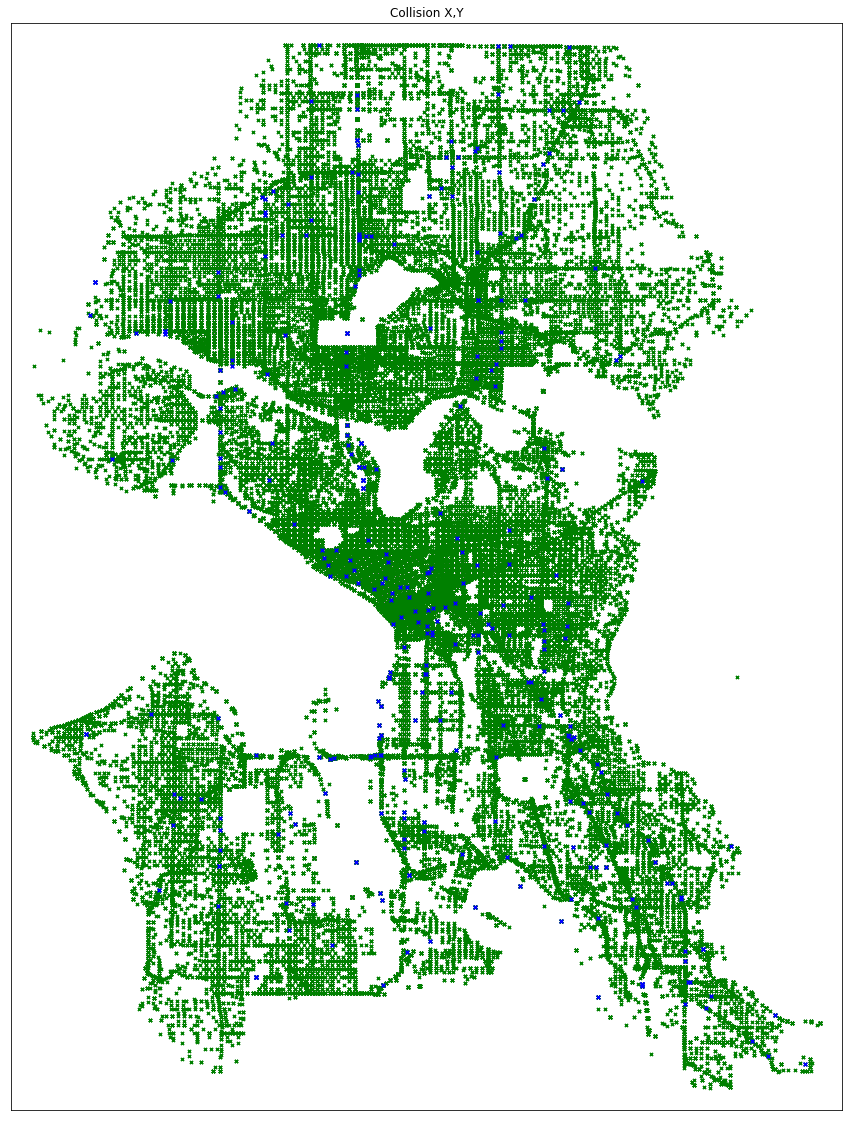

In [55]:
draw_map(df_new,'FATALITIES')

## Considering detail level we need for X, Y

In [56]:
def convert_degrees_to_feet(n_deg):
    return (n_deg * 10000 * 3280.4 / 90)

convert_degrees_to_feet(1)  # 1 degree is 364 feet

convert_degrees_to_feet(-104.673) # DIA example from https://sciencing.com/convert-latitude-longtitude-feet-2724.html

convert_degrees_to_feet(.01)  # .01 degree is 3644 feet

convert_degrees_to_feet(.00001)  # .00001 degree is 3.644 feet -- this is more than enough precision!

# Round the X,Y to 5 decimal places 
np.round(3.644888888888889,5)

#df['X'] = df['X'].apply(lambda x: np.round(x,5))

#df['X'].head()

#df['Y'] = df['Y'].apply(lambda x: np.round(x,5))

df.groupby(['LOCATION','X','Y'])[['LOCATION','X','Y']].count()

364488.8888888889

-38152145.46666667

3644.8888888888887

3.644888888888889

3.64489

,,,LOCATION,X,Y
LOCATION,X,Y,,,
10TH AVE AND E ALDER ST,-122.319411,47.604360,1,1,1
10TH AVE AND E JEFFERSON ST,-122.319416,47.606209,11,11,11
10TH AVE AND E MADISON ST,-122.319348,47.611758,10,10,10
10TH AVE AND E PIKE ST,-122.319447,47.614085,25,25,25
10TH AVE AND E PINE ST,-122.319465,47.615245,23,23,23
...,...,...,...,...,...
YESLER WAY BETWEEN TERRACE ST AND 6TH AVE,-122.327686,47.601712,26,26,26
YESLER WAY BETWEEN WESTERN AVE AND POST AVE,-122.335217,47.601723,4,4,4
YORK RD S BETWEEN 36TH AVE S AND 37TH AVE S,-122.286848,47.572360,4,4,4


## What do these mean in terms of distance?

10TH AVE AND E PIKE ST	-122.31945	47.61409	25	25	25     


10TH AVE AND E PINE ST	-122.31947	47.61525	23	23	23

In [57]:
convert_degrees_to_feet(47.61525 - 47.61409) # 422 feet

convert_degrees_to_feet(-122.31945 - -122.31947)

# Look for all entries in original data that include 10TH AVE AND E PIKE ST
df_10pike = df[df['LOCATION'] == '10TH AVE AND E PIKE ST'].copy()

df_10pike[['X','Y','LOCATION','ADDRTYPE','INCDATE','JUNCTIONTYPE']].count()

# Spokane street oddity -- this was eclipsed when I did the drop duplicates for the location_xy.csv
convert_degrees_to_feet(-122.33094 - -122.33194) 
# 364 foot -- looked at Google Earth -- they are near each other on same roadway; nearest intersection is correct
#    no need to adjust since there are no other uses of this text LOCATION string

422.8071111132336

7.289777774911954

X               25
Y               25
LOCATION        25
ADDRTYPE        25
INCDATE         25
JUNCTIONTYPE    25
dtype: int64

364.4888888906293